# Clustering com K-Means, DBSCA e Mean Shift

In [1]:
import random
import joblib
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator
from scipy.spatial import distance
from itertools import cycle

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

### Carregando Dados

In [2]:
arquivo_excel = 'dados/OperacoesPortabilidade.xlsx'

df_realizado = pd.read_excel(arquivo_excel, sheet_name='Realizado', header=1, index_col=0)

In [3]:
df_realizado.shape

(1000, 10)

In [4]:
df_realizado.columns

Index(['Data', 'Produto', 'Cliente', 'Taxa', 'Prazo Atual', 'Parcelas Pagas',
       'IF', 'PMT', 'Saldo Devedor Inicial', 'Saldo Devedor Atual'],
      dtype='object')

In [5]:
df_realizado

,Data,Produto,Cliente,Taxa,Prazo Atual,Parcelas Pagas,IF,PMT,Saldo Devedor Inicial,Saldo Devedor Atual
10,2023-10-15,Cartão,609,0.0150,69,15,99,204.47,9728.403092,8751.764792
2,2023-02-09,Cartão,387,0.0176,18,66,197,250.92,10964.162233,3842.404097
9,2023-09-27,Cartão,396,0.0187,27,57,44,563.24,23767.030229,11855.545606
8,2023-08-04,Seguro,43,0.0180,2,82,107,273.32,11791.431200,532.227141
6,2023-06-30,Cartão,214,0.0095,73,11,36,447.39,25810.749547,23477.970903
...,...,...,...,...,...,...,...,...,...,...
11,2023-11-13,Crédito Pessoal,956,0.0182,84,0,55,436.07,18693.596907,18693.596907
9,2023-09-26,Cartão,956,0.0110,81,3,98,202.76,11079.253839,10833.910118
8,2023-08-08,Seguro,146,0.0127,69,15,129,160.18,8243.251489,7332.662164
2,2023-02-19,Crédito Pessoal,777,0.0198,70,14,25,128.34,5233.181171,4838.785090


### Análise Exploratória

In [6]:
# Tipos dos Dados
df_realizado.dtypes

Data                     datetime64[ns]
Produto                          object
Cliente                           int64
Taxa                            float64
Prazo Atual                       int64
Parcelas Pagas                    int64
IF                                int64
PMT                             float64
Saldo Devedor Inicial           float64
Saldo Devedor Atual             float64
dtype: object

#### - Variáveis Numéricas

In [7]:
df_realizado.describe()

,Data,Cliente,Taxa,Prazo Atual,Parcelas Pagas,IF,PMT,Saldo Devedor Inicial,Saldo Devedor Atual
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2023-06-28 21:27:21.599999744,497.594000,0.014425,41.932000,42.068000,98.306000,335.250020,16422.981014,9670.083921
min,2023-01-01 00:00:00,1.000000,0.008000,1.000000,0.000000,1.000000,50.530000,2135.842526,52.132795
25%,2023-03-27 00:00:00,242.500000,0.011200,21.000000,21.000000,47.750000,203.270000,9924.549380,3834.703107
50%,2023-06-27 00:00:00,491.000000,0.014300,41.000000,43.000000,97.000000,340.920000,16242.910390,8369.136445
75%,2023-09-30 06:00:00,753.250000,0.017700,63.000000,63.000000,149.000000,473.875000,22751.439606,14496.600370
max,2024-01-01 00:00:00,999.000000,0.021000,84.000000,83.000000,200.000000,599.940000,36164.720565,31750.240031
std,NaN,290.607839,0.003809,24.416706,24.416706,57.954526,158.136803,8063.211017,6933.061179


In [8]:
#Total Clientes
total_cliente = len(df_realizado['Cliente'].unique())
total_cliente

629

In [9]:
#Criando medidas de RFM para apoiar na clusterização

datareferencia = dt.datetime(2024, 10, 25)

rfm = df_realizado.groupby('Cliente').agg({
    'Data' : lambda x: (datareferencia - x.max()).days,
     'Cliente' : 'count',
    'Saldo Devedor Inicial' : 'sum'
}). rename(columns={'Data':'Recencia', 'Cliente':'Frequencia', 'Saldo Devedor Inicial':'Monetario'}).reset_index()

rfm

,Cliente,Recencia,Frequencia,Monetario
0,1,305,1,13959.764853
1,2,302,1,5212.372354
2,3,323,3,47492.356218
3,4,579,3,58356.899051
4,5,328,2,24403.934382
...,...,...,...,...
624,995,558,3,71850.036158
625,996,298,2,51164.521118
626,997,417,2,35387.560791
627,998,315,3,53061.971204


In [10]:
rfm['R_score'] = pd.cut(rfm['Recencia'], 4, labels=[4, 3, 2, 1], include_lowest=True)
rfm['F_score'] = pd.cut(rfm['Frequencia'], 4, labels=[1, 2, 3, 4], include_lowest=True)
rfm['M_score'] = pd.cut(rfm['Monetario'], 4, labels=[1, 2, 3, 4], include_lowest=True)

rfm['RFM_Score'] = rfm['R_score'].astype(int) + rfm['F_score'].astype(int) + rfm['M_score'].astype(int)

rfm

,Cliente,Recencia,Frequencia,Monetario,R_score,F_score,M_score,RFM_Score
0,1,305,1,13959.764853,4,1,1,6
1,2,302,1,5212.372354,4,1,1,6
2,3,323,3,47492.356218,4,2,2,8
3,4,579,3,58356.899051,1,2,3,6
4,5,328,2,24403.934382,4,1,1,6
...,...,...,...,...,...,...,...,...
624,995,558,3,71850.036158,2,2,3,7
625,996,298,2,51164.521118,4,1,2,7
626,997,417,2,35387.560791,3,1,2,6
627,998,315,3,53061.971204,4,2,3,9


In [11]:
df_realizado = pd.merge(df_realizado, rfm[['Cliente', 'RFM_Score']], on='Cliente', how='left')

df_realizado

,Data,Produto,Cliente,Taxa,Prazo Atual,Parcelas Pagas,IF,PMT,Saldo Devedor Inicial,Saldo Devedor Atual,RFM_Score
0,2023-10-15,Cartão,609,0.0150,69,15,99,204.47,9728.403092,8751.764792,8
1,2023-02-09,Cartão,387,0.0176,18,66,197,250.92,10964.162233,3842.404097,4
2,2023-09-27,Cartão,396,0.0187,27,57,44,563.24,23767.030229,11855.545606,9
3,2023-08-04,Seguro,43,0.0180,2,82,107,273.32,11791.431200,532.227141,5
4,2023-06-30,Cartão,214,0.0095,73,11,36,447.39,25810.749547,23477.970903,7
...,...,...,...,...,...,...,...,...,...,...,...
995,2023-11-13,Crédito Pessoal,956,0.0182,84,0,55,436.07,18693.596907,18693.596907,10
996,2023-09-26,Cartão,956,0.0110,81,3,98,202.76,11079.253839,10833.910118,10
997,2023-08-08,Seguro,146,0.0127,69,15,129,160.18,8243.251489,7332.662164,5
998,2023-02-19,Crédito Pessoal,777,0.0198,70,14,25,128.34,5233.181171,4838.785090,5


In [12]:
#Criando a coluna Renda Estimada do cliente

renda = df_realizado.groupby('Cliente').agg({
     'PMT' : lambda x: (sum(x * 4))
}).rename(columns={'PMT':'Renda Mensal Estimada'}).reset_index()

renda

,Cliente,Renda Mensal Estimada
0,1,1119.28
1,2,457.48
2,3,4504.72
3,4,4903.44
4,5,1830.84
...,...,...
624,995,5699.08
625,996,4159.60
626,997,2819.64
627,998,4259.28


In [13]:
df_realizado = pd.merge(df_realizado, renda[['Cliente', 'Renda Mensal Estimada']], on='Cliente', how='left')

df_realizado

,Data,Produto,Cliente,Taxa,Prazo Atual,Parcelas Pagas,IF,PMT,Saldo Devedor Inicial,Saldo Devedor Atual,RFM_Score,Renda Mensal Estimada
0,2023-10-15,Cartão,609,0.0150,69,15,99,204.47,9728.403092,8751.764792,8,2963.24
1,2023-02-09,Cartão,387,0.0176,18,66,197,250.92,10964.162233,3842.404097,4,2090.56
2,2023-09-27,Cartão,396,0.0187,27,57,44,563.24,23767.030229,11855.545606,9,4844.00
3,2023-08-04,Seguro,43,0.0180,2,82,107,273.32,11791.431200,532.227141,5,1093.28
4,2023-06-30,Cartão,214,0.0095,73,11,36,447.39,25810.749547,23477.970903,7,2760.64
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023-11-13,Crédito Pessoal,956,0.0182,84,0,55,436.07,18693.596907,18693.596907,10,5016.76
996,2023-09-26,Cartão,956,0.0110,81,3,98,202.76,11079.253839,10833.910118,10,5016.76
997,2023-08-08,Seguro,146,0.0127,69,15,129,160.18,8243.251489,7332.662164,5,1565.76
998,2023-02-19,Crédito Pessoal,777,0.0198,70,14,25,128.34,5233.181171,4838.785090,5,1019.60


In [14]:
datareferencia = dt.datetime(2024, 11, 25)

df_realizado['Data'] = df_realizado['Data'].apply(lambda x: (datareferencia - x).days)

df_realizado

,Data,Produto,Cliente,Taxa,Prazo Atual,Parcelas Pagas,IF,PMT,Saldo Devedor Inicial,Saldo Devedor Atual,RFM_Score,Renda Mensal Estimada
0,407,Cartão,609,0.0150,69,15,99,204.47,9728.403092,8751.764792,8,2963.24
1,655,Cartão,387,0.0176,18,66,197,250.92,10964.162233,3842.404097,4,2090.56
2,425,Cartão,396,0.0187,27,57,44,563.24,23767.030229,11855.545606,9,4844.00
3,479,Seguro,43,0.0180,2,82,107,273.32,11791.431200,532.227141,5,1093.28
4,514,Cartão,214,0.0095,73,11,36,447.39,25810.749547,23477.970903,7,2760.64
...,...,...,...,...,...,...,...,...,...,...,...,...
995,378,Crédito Pessoal,956,0.0182,84,0,55,436.07,18693.596907,18693.596907,10,5016.76
996,426,Cartão,956,0.0110,81,3,98,202.76,11079.253839,10833.910118,10,5016.76
997,475,Seguro,146,0.0127,69,15,129,160.18,8243.251489,7332.662164,5,1565.76
998,645,Crédito Pessoal,777,0.0198,70,14,25,128.34,5233.181171,4838.785090,5,1019.60


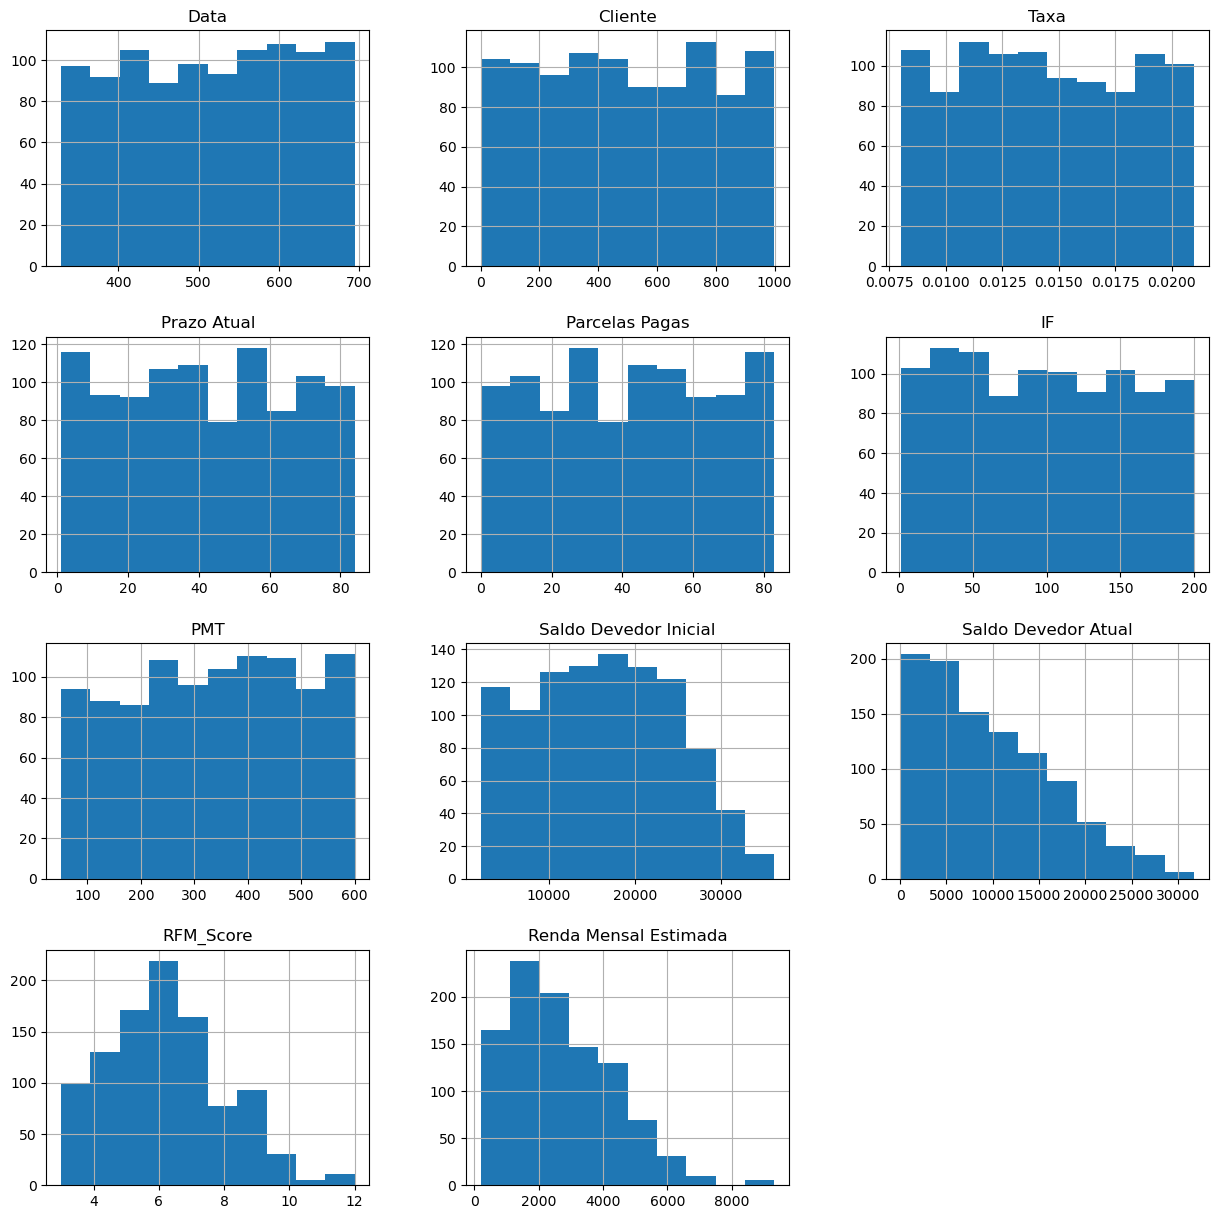

In [15]:
df_realizado.hist(figsize = (15,15), bins = 10)
plt.show()

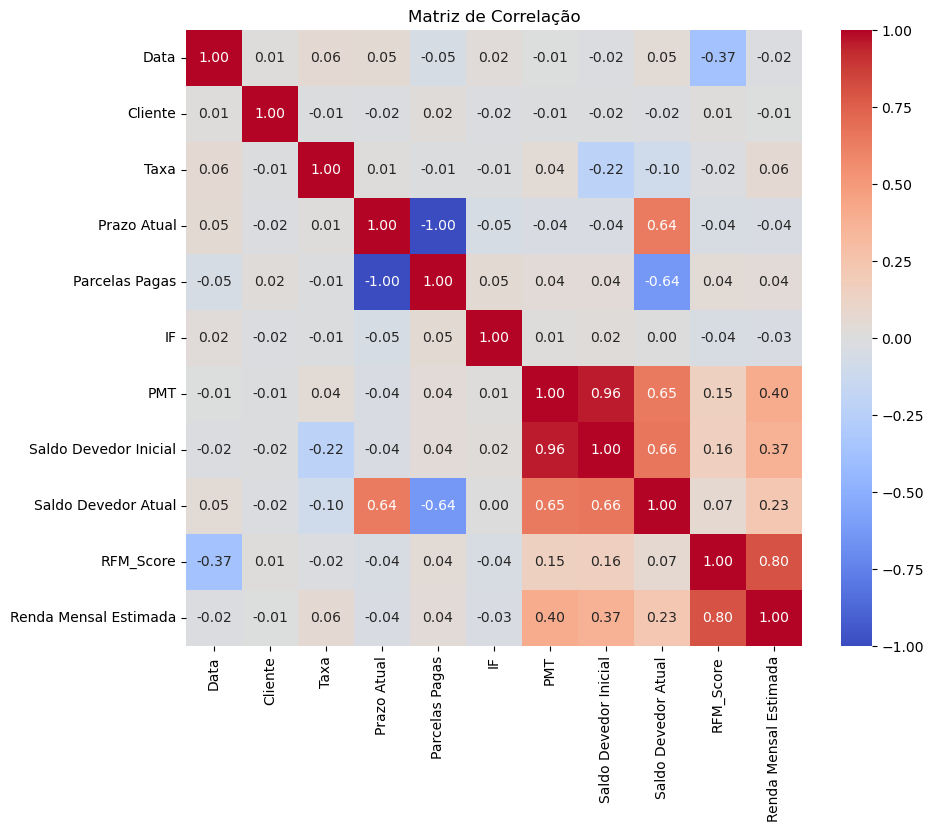

In [16]:
df_corr = df_realizado.select_dtypes(exclude=['object'])

correlation_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
ax.set_title('Matriz de Correlação')

#salvando figura
#fig.savefig('corr.png', format='png')
plt.show() 

##### Podemos observar que as variáveis Saldo Devedor Atual e PMT, possuem uma alta correlação positiva (0.96), indicando que podem representar a mesma informação, o que caracteriza-se como Multicolinearidade. 
##### Para evitar que o modelo fique tendencioso vamos retirar uma das variáveis. 
##### Como padrão, utiliza-se o valor de correlação acima de 0.70 como indicativo.

#### - Variáveis Categoricas

In [17]:
df_realizado.describe(include = ['object'])

,Produto
count,1000
unique,5
top,Cartão
freq,218


Numero de portabilidade de Cartão:  218
Numero de portabilidade de Seguro:  209
Numero de portabilidade de Pix:  179
Numero de portabilidade de Consignado:  206
Numero de portabilidade de Crédito Pessoal:  188


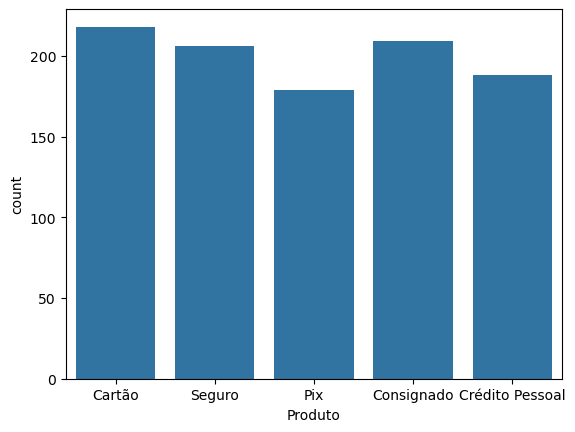

In [18]:
sns.countplot(data = df_realizado, x = 'Produto')

CT, S, CO, CP, P = df_realizado['Produto'].value_counts()

print('Numero de portabilidade de Cartão: ', CT)
print('Numero de portabilidade de Seguro: ', S)
print('Numero de portabilidade de Pix: ', P)
print('Numero de portabilidade de Consignado: ', CO)
print('Numero de portabilidade de Crédito Pessoal: ', CP)

In [19]:
#Enconding Variave Produto

mapping_dic = { 'Cartão' : 1,
                'Seguro' : 2,
                'Pix' : 3,
                'Consignado' : 4,
                'Crédito Pessoal' : 5
              }


df_realizado['Produto'] = df_realizado.Produto.map(mapping_dic)

df_realizado

,Data,Produto,Cliente,Taxa,Prazo Atual,Parcelas Pagas,IF,PMT,Saldo Devedor Inicial,Saldo Devedor Atual,RFM_Score,Renda Mensal Estimada
0,407,1,609,0.0150,69,15,99,204.47,9728.403092,8751.764792,8,2963.24
1,655,1,387,0.0176,18,66,197,250.92,10964.162233,3842.404097,4,2090.56
2,425,1,396,0.0187,27,57,44,563.24,23767.030229,11855.545606,9,4844.00
3,479,2,43,0.0180,2,82,107,273.32,11791.431200,532.227141,5,1093.28
4,514,1,214,0.0095,73,11,36,447.39,25810.749547,23477.970903,7,2760.64
...,...,...,...,...,...,...,...,...,...,...,...,...
995,378,5,956,0.0182,84,0,55,436.07,18693.596907,18693.596907,10,5016.76
996,426,1,956,0.0110,81,3,98,202.76,11079.253839,10833.910118,10,5016.76
997,475,2,146,0.0127,69,15,129,160.18,8243.251489,7332.662164,5,1565.76
998,645,5,777,0.0198,70,14,25,128.34,5233.181171,4838.785090,5,1019.60


In [20]:
df_realizado[df_realizado.isnull().values]

,Data,Produto,Cliente,Taxa,Prazo Atual,Parcelas Pagas,IF,PMT,Saldo Devedor Inicial,Saldo Devedor Atual,RFM_Score,Renda Mensal Estimada


In [21]:
df_realizado[df_realizado.duplicated(keep = False)]

,Data,Produto,Cliente,Taxa,Prazo Atual,Parcelas Pagas,IF,PMT,Saldo Devedor Inicial,Saldo Devedor Atual,RFM_Score,Renda Mensal Estimada


### Pré Processamento Normalização

In [22]:
df_realizado_norm_km = df_realizado.drop(columns=['Cliente'])
df_realizado_norm_db = df_realizado_norm_km.copy()
df_realizado_norm_ms = df_realizado_norm_km.copy()
df_realizado_norm_km

,Data,Produto,Taxa,Prazo Atual,Parcelas Pagas,IF,PMT,Saldo Devedor Inicial,Saldo Devedor Atual,RFM_Score,Renda Mensal Estimada
0,407,1,0.0150,69,15,99,204.47,9728.403092,8751.764792,8,2963.24
1,655,1,0.0176,18,66,197,250.92,10964.162233,3842.404097,4,2090.56
2,425,1,0.0187,27,57,44,563.24,23767.030229,11855.545606,9,4844.00
3,479,2,0.0180,2,82,107,273.32,11791.431200,532.227141,5,1093.28
4,514,1,0.0095,73,11,36,447.39,25810.749547,23477.970903,7,2760.64
...,...,...,...,...,...,...,...,...,...,...,...
995,378,5,0.0182,84,0,55,436.07,18693.596907,18693.596907,10,5016.76
996,426,1,0.0110,81,3,98,202.76,11079.253839,10833.910118,10,5016.76
997,475,2,0.0127,69,15,129,160.18,8243.251489,7332.662164,5,1565.76
998,645,5,0.0198,70,14,25,128.34,5233.181171,4838.785090,5,1019.60


In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))

df_realizado_norm_km = scaler.fit_transform(df_realizado_norm_km)
df_realizado_norm_db = scaler.fit_transform(df_realizado_norm_db)
df_realizado_norm_ms = scaler.fit_transform(df_realizado_norm_ms)

print("Normalização Min-Max:\n", df_realizado_norm_km)

Normalização Min-Max:
 [[0.21369863 0.         0.53846154 ... 0.27445273 0.55555556 0.30270477]
 [0.89315068 0.         0.73846154 ... 0.11957406 0.11111111 0.20700274]
 [0.2630137  0.         0.82307692 ... 0.37236964 0.66666667 0.5089574 ]
 ...
 [0.4        0.25       0.36153846 ... 0.22968341 0.22222222 0.1494508 ]
 [0.86575342 1.         0.90769231 ... 0.15100751 0.22222222 0.08955643]
 [0.16712329 0.5        0.93846154 ... 0.05211546 0.55555556 0.32198817]]


#### Identificado se o DataFrame é clusterizavel

In [24]:
# Aplicando Hopkins para identificar se o dataframe é clusterizavel
def hopkins_statistic(data, n=None):

    if n is None:
        n = len(data)

    data = np.array(data)
    
    random_indices = random.sample(range(len(data)), n)
    random_points = data[random_indices]
    
    d1 = []
    d2 = []
    
    for point in random_points:
        distances = distance.cdist([point], data, 'euclidean')[0]
        sorted_distances = np.sort(distances) 
        d1.append(sorted_distances[1]) 
        d2.append(sorted_distances[2])  

    D1_sum = np.sum(d1)
    D2_sum = np.sum(d2)
    
    H = D1_sum / (D1_sum + D2_sum)
    
    return H

In [25]:
hopkins = hopkins_statistic(df_realizado_norm_km)

print(f'Índice de Hopkins: {hopkins}')

Índice de Hopkins: 0.462310110622147


###### O valor 0.462 para índice de hopkins indica que há uma leve tendência para agrupamento nos dados, mas nada muito claro ou bem estruturado. 

#### Identificando o número ideal de cluster

  File "C:\Users\leand\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


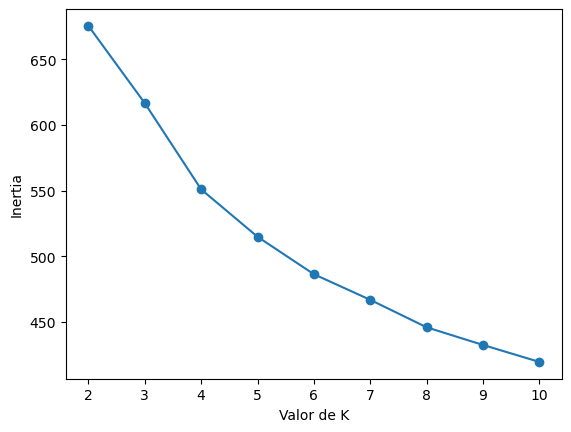

In [26]:
# Inercia - Soma da distancia em relação ao centro
Ks = range(2, 11) 

valor_metrica = []

for k in Ks:
    modelo = KMeans(n_clusters=k, random_state = 101)
    modelo.fit(df_realizado_norm_km)
    valor_metrica.append(modelo.inertia_)

plt.plot(Ks, valor_metrica, 'o-')
plt.xlabel('Valor de K')
plt.ylabel('Inertia')
plt.show()

O número ideal de clusters é: 3


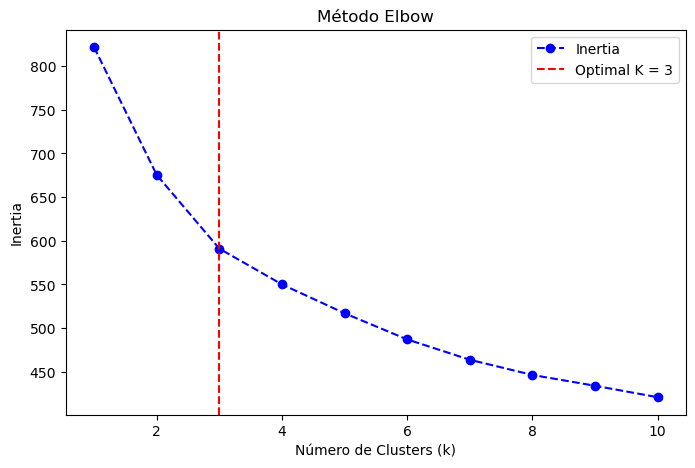

In [27]:
# Método de Elbow

inertia = []
range_n_clusters = range(1, 11) 

for k in range_n_clusters:
    kmeans = KMeans(n_clusters = k,
                    init = 'k-means++',
                    random_state=111)
    kmeans.fit(df_realizado_norm_km)
    inertia.append(kmeans.inertia_)

knee_locator = KneeLocator(range_n_clusters, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

print(f"O número ideal de clusters é: {optimal_k}")

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker="o", linestyle="--", color="b", label="Inertia")
plt.axvline(x=optimal_k, color="r", linestyle="--", label=f"Optimal K = {optimal_k}")
plt.title("Método Elbow")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inertia")
plt.legend()
plt.show()

In [28]:
# K-Means para gerar pseudo-rótulos com a quantidade de cluster indicado no metodo de elbow
df_realizado2 = df_realizado.copy()
df_realizado_norm2 = df_realizado2.drop(columns=["Cliente"])

kmeans = KMeans(n_clusters=3, random_state=42)
pseudo_labels = kmeans.fit_predict(df_realizado_norm2) 
df_realizado_norm2['labels'] = pseudo_labels

print(df_realizado_norm2.head())

   Data  Produto    Taxa  Prazo Atual  Parcelas Pagas   IF     PMT  \
0   407        1  0.0150           69              15   99  204.47   
1   655        1  0.0176           18              66  197  250.92   
2   425        1  0.0187           27              57   44  563.24   
3   479        2  0.0180            2              82  107  273.32   
4   514        1  0.0095           73              11   36  447.39   

   Saldo Devedor Inicial  Saldo Devedor Atual  RFM_Score  \
0            9728.403092          8751.764792          8   
1           10964.162233          3842.404097          4   
2           23767.030229         11855.545606          9   
3           11791.431200           532.227141          5   
4           25810.749547         23477.970903          7   

   Renda Mensal Estimada  labels  
0                2963.24       1  
1                2090.56       1  
2                4844.00       2  
3                1093.28       1  
4                2760.64       0  


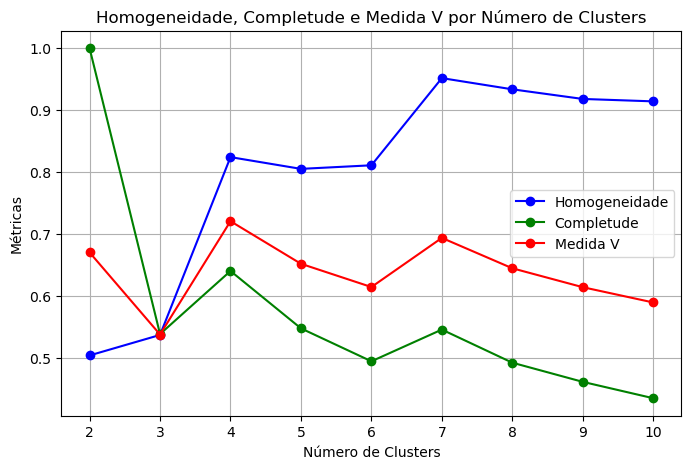

In [29]:
# Homogeneidade - pontos de dados do cluster membros de uma unica classe
# Completude - pontos de dados de uma classe membros do mesmo cluster
# V Measure - media homogeneidade / completude

X = df_realizado_norm2.drop(columns=["labels"]) 
y_pred = df_realizado_norm2["labels"]  

scaler = MinMaxScaler(feature_range=(0, 1))
df_realizado_norm2 = scaler.fit_transform(df_realizado_norm2)
#print("Normalização Min-Max:\n", df_realizado_norm)

# Testando diferentes números de clusters
range_n_clusters = range(2, 11)
homogeneity = []
completeness = []
v_measure = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_realizado_norm2)
    
    # Calcular as métricas
    homogeneity.append(homogeneity_score(y_pred, labels))
    completeness.append(completeness_score(y_pred, labels))
    v_measure.append(v_measure_score(y_pred, labels))

# Plotar as métricas
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, homogeneity, label="Homogeneidade", marker="o", color="b")
plt.plot(range_n_clusters, completeness, label="Completude", marker="o", color="g")
plt.plot(range_n_clusters, v_measure, label="Medida V", marker="o", color="r")
plt.title("Homogeneidade, Completude e Medida V por Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Métricas")
plt.legend()
plt.grid(True)
plt.show()


#### Modelo de Clustering

##### K- Means

In [30]:
kmeans = KMeans(n_clusters = 3,
                init = 'k-means++',
                random_state = 111)
kmeans.fit(df_realizado_norm_km)

KMeans(n_clusters=3, random_state=111)

In [31]:
n_clusters = len(set(kmeans.labels_))
n_clusters , kmeans.labels_

(3,
 array([1, 2, 2, 2, 0, 1, 1, 0, 0, 2, 1, 1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0,
        0, 2, 0, 1, 2, 2, 1, 0, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 1, 1, 0, 2,
        0, 1, 2, 1, 1, 2, 0, 1, 0, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 2,
        0, 1, 2, 2, 2, 0, 2, 1, 0, 0, 0, 0, 1, 2, 2, 0, 0, 2, 1, 1, 1, 2,
        2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 0, 2, 0, 2, 0, 0, 2, 1, 0, 0, 0,
        0, 2, 0, 0, 2, 0, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 0, 0, 2,
        2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1,
        0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 0, 2, 1, 1, 2, 2, 2, 2, 0, 0, 0, 2,
        1, 0, 2, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
        2, 1, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 0, 0, 2, 1, 1, 2, 2, 1, 0, 1,
        0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 2, 2, 1,
        2, 2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1,
        2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 2, 0, 2, 2, 2, 0, 0,

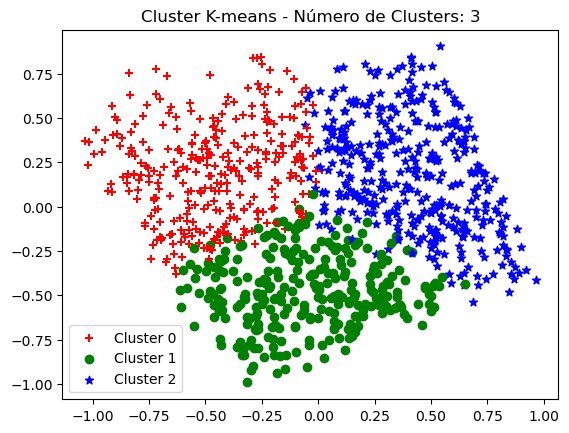

In [32]:
pca = PCA(n_components = 2).fit(df_realizado_norm_km)
pca2d = pca.transform(df_realizado_norm_km)

for i in range(0, pca2d.shape[0]):
    if kmeans.labels_[i] == 0:
        c1 = plt.scatter(pca2d[i,0],pca2d[i,1], c = 'r', marker = '+')

    elif kmeans.labels_[i] == 1:
        c2 = plt.scatter(pca2d[i,0],pca2d[i,1], c = 'g', marker = 'o')

    elif kmeans.labels_[i] == 2:
        c3 = plt.scatter(pca2d[i,0],pca2d[i,1], c = 'b', marker = '*')
        
plt.legend([c1,c2,c3],['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.title('Cluster K-means - Número de Clusters: %d' % n_clusters)

plt.show()

In [33]:
score = silhouette_score(df_realizado_norm_km, kmeans.labels_ )
if score > 0.5:
    obs = 'Boa clusterização pois o Silhoutte Score é > 0.5'
else:
    obs = 'Silhoutte Score ficar < 0.5 recomenda-se reavaliar o dataframe ou as métricas, para alcançar > 0.5'
    
score

0.15452039773559728

In [34]:
df_modelos = pd.DataFrame()

dict_kmeans = {'Algoritmo' : 'KMeans',
               'Silhouette Score' : score,
               'OBS' : obs}

new_row = pd.DataFrame([dict_kmeans])

df_modelos = pd.concat([df_modelos, new_row], ignore_index=True)
df_modelos

,Algoritmo,Silhouette Score,OBS
0,KMeans,0.15452,Silhoutte Score ficar < 0.5 recomenda-se reava...


##### DBSCAN

In [53]:
dbscan_v1 = DBSCAN(eps=0.3, min_samples=3)

dbscan_v1.fit(df_realizado_norm_db)

DBSCAN(eps=0.3, min_samples=3)

In [54]:
labels = dbscan_v1.labels_[dbscan_v1.labels_ != -1]
n_clusters = len(set(dbscan_v1.labels_)) - (1 if -1 in dbscan_v1.labels_ else 0)

n_clusters, labels

(25,
 array([ 8,  0, 16,  1,  4,  2, 23, 17,  3, 14,  4,  4,  5,  6, 17,  0,  7,
        20, 21,  9, 11,  3,  7,  8, 24,  9, 10,  6,  4, 13,  9, 19, 11,  8,
         5, 10,  4, 12, 21, 20, 16,  4, 12, 13, 14,  5,  1, 15, 16, 24, 15,
        10, 15, 12, 22,  3,  1, 18,  2,  6, 17,  7, 18, 22, 10, 19, 20, 13,
         4, 23, 18, 19, 21, 16, 14,  4,  0, 22, 23, 24,  9,  2, 11,  1,  4,
         4], dtype=int64))

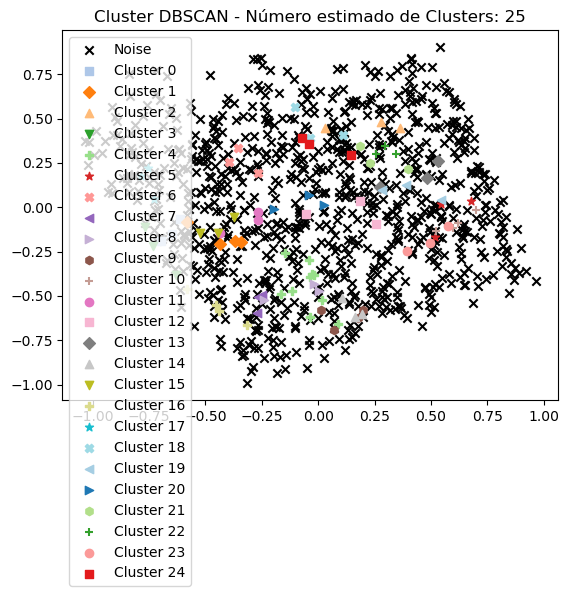

In [37]:
pca = PCA(n_components=2).fit(df_realizado_norm_db)
pca2d = pca.transform(df_realizado_norm_db)

unique_labels = sorted(set(dbscan_v1.labels_))
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

colors = list(plt.cm.tab20.colors) + list(plt.cm.Paired.colors) 
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', '<', '>', 'h', '+'] * 3 

colors = colors * (len(unique_labels) // len(colors) + 1)
markers = markers * (len(unique_labels) // len(markers) + 1)

label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

for cluster_id in unique_labels:
    if cluster_id == -1:  # Tratar ruído separadamente
        plt.scatter(pca2d[dbscan_v1.labels_ == -1, 0],
                    pca2d[dbscan_v1.labels_ == -1, 1],
                    c='k', marker='x', label='Noise')
    else:
        idx = dbscan_v1.labels_ == cluster_id
        color_idx = label_to_index[cluster_id]
        plt.scatter(pca2d[idx, 0],
                    pca2d[idx, 1],
                    c=[colors[color_idx]],
                    marker=markers[color_idx],
                    label=f'Cluster {cluster_id}')
        
plt.legend()
plt.title('Cluster DBSCAN - Número estimado de Clusters: %d' % n_clusters)

plt.show()

In [38]:
if n_clusters > 1:  
    score = silhouette_score(df_realizado_norm_km, dbscan_v1.labels_)
    print(f"Silhouette Score (excluindo outliers): {score}")
else:
    score = 0
    obs = "Silhouette Score não pode ser calculado com menos de 2 clusters válidos."
    print("Silhouette Score não pode ser calculado com menos de 2 clusters válidos.")

Silhouette Score (excluindo outliers): -0.3859684336776191


In [39]:
dict_DBSCAN = {'Algoritmo' : 'DBSCAN',
               'Silhouette Score' : score,
               'OBS' : obs}

new_row = pd.DataFrame([dict_DBSCAN])

df_modelos = pd.concat([df_modelos, new_row], ignore_index=True)
df_modelos

,Algoritmo,Silhouette Score,OBS
0,KMeans,0.154520,Silhoutte Score ficar < 0.5 recomenda-se reava...
1,DBSCAN,-0.385968,Silhoutte Score ficar < 0.5 recomenda-se reava...


##### Mean Shift

In [40]:
bandwidth = estimate_bandwidth(df_realizado_norm_ms, quantile = .1,  n_samples = 500, )

meanshift_v1 = MeanShift(bandwidth = bandwidth, bin_seeding = True)

meanshift_v1.fit(df_realizado_norm_ms)

MeanShift(bandwidth=0.8607115799424019, bin_seeding=True)

In [41]:
labels = meanshift_v1.labels_[meanshift_v1.labels_ != -1]
n_clusters = len(np.unique(labels))

n_clusters, labels

(1,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0,

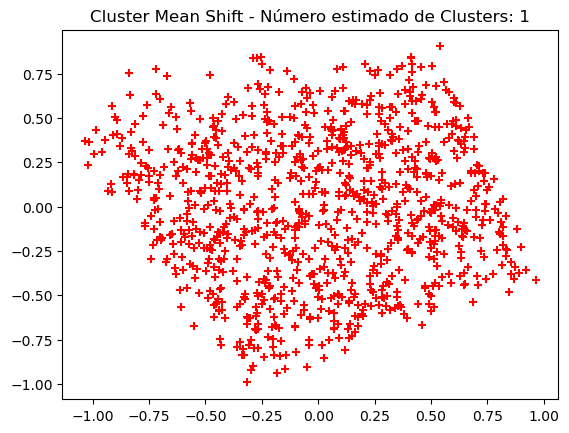

In [42]:
pca = PCA(n_components = 2).fit(df_realizado_norm_ms)
pca2d = pca.transform(df_realizado_norm_ms)

for i in range(0, pca2d.shape[0]):
    if meanshift_v1.labels_[i] == 0:
        c1 = plt.scatter(pca2d[i,0],pca2d[i,1], c = 'r', marker = '+')
        
    elif meanshift_v1.labels_[i] == 1:
         c2 = plt.scatter(pca2d[i,0],pca2d[i,1], c = 'g', marker = 'o')
        
    elif meanshift_v1.labels_[i] == 2:
        c3 = plt.scatter(pca2d[i,0],pca2d[i,1], c = 'b', marker = '*')
        

plt.title('Cluster Mean Shift - Número estimado de Clusters: %d' % n_clusters)

plt.show()

In [43]:
if n_clusters > 1: 
    score = silhouette_score(df_realizado_norm_ms, labels)
    print(f"Silhouette Score: {score}")
else:
    score = 0
    obs = "Silhouette Score não pode ser calculado com menos de 2 clusters válidos."
    print("Silhouette Score não pode ser calculado com menos de 2 clusters.")

Silhouette Score não pode ser calculado com menos de 2 clusters.


In [44]:
dict_MeanShift = {'Algoritmo' : 'Mean Shift',
                  'Silhouette Score' : score,
                  'OBS' : obs}

new_row = pd.DataFrame([dict_MeanShift])

df_modelos = pd.concat([df_modelos, new_row], ignore_index=True)

#### Avaliação dos Modelos

In [45]:
df_modelos

,Algoritmo,Silhouette Score,OBS
0,KMeans,0.154520,Silhoutte Score ficar < 0.5 recomenda-se reava...
1,DBSCAN,-0.385968,Silhoutte Score ficar < 0.5 recomenda-se reava...
2,Mean Shift,0.000000,Silhouette Score não pode ser calculado com me...


In [46]:
distances = distance.pdist(df_realizado_norm_km, metric='euclidean')
print(f"Distância média: {np.mean(distances):.4f}, Desvio padrão: {np.std(distances):.4f}")

Distância média: 1.2435, Desvio padrão: 0.3144


##### Pouca variabilidade espacial, dados não heterogêneo, distribuidos de maneira uniforme no espaço multidimensional, não apresenta agrupamentos naturais claros 

In [47]:
df_realizado.groupby('Produto').agg({
     'Renda Mensal Estimada' : 'mean'
}).reset_index()

,Produto,Renda Mensal Estimada
0,1,2842.824220
1,2,2673.100777
2,3,2670.735196
3,4,2620.864115
4,5,2706.181915


In [48]:
df_realizado.groupby('Produto').agg({
     'PMT' : 'mean'
}).reset_index()

,Produto,PMT
0,1,337.833073
1,2,321.788107
2,3,329.125196
3,4,337.874785
4,5,349.919255
